<a href="https://colab.research.google.com/github/Aurelien07/Kaggle_competition/blob/main/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit  Recognizer project :

Dans ce projet notre sommaire sera quelque chose similaire à ça : 

- Visualisation des données 
- Pré-traitement des données
- Choix d'un modéle (from scratch)
  - Entrainement du modéle 
  - Evaluation du modéle
  - Prédictions sur les données de test
- Choix du modéle (Transfert Learning)
  - Entrainement du modéle
  - Evaluation du modéle
  - Prédictions sur les données de test
- Comparatif entre from Scratch et Transfert Learning
- Optimisation du modéle avec GridsearchCV
- Script de détection
- Conclusion


## Visualisation des données :

In [ ]:
def visu(data):
    """
    Permet d'afficher une visualisation personnalisée des informations d'un DataFrame.

    Parameters:
    ----------
    data : pd.DataFrame
        DataFrame contenant les données à visualiser.
    """

    print('-'*100)
    print(" " * 45 + '\033[1m' + "Shape :" + '\033[0m')
    print('-'*100)
    print(f"Le nombre de lignes et de colonnes dans le DataFrame est de : {data.shape}\n")
    print('-'*100)
    print(" " * 45 + '\033[1m' + "Head :" + '\033[0m')
    print('-'*100)
    
    while True:
        try:
            num_rows = int(input("Entrez le nombre de lignes à afficher : "))
            if num_rows > 0:
                break
            else:
                print("Le nombre de lignes doit être un Integer.")
        except ValueError:
            print("Veuillez entrer un Integer.")
    
    display(data.head(num_rows))
    
    print('-'*100)
    print(" " * 45 + '\033[1m' + "Describe :" + '\033[0m')
    print('-'*100)
    
    while True:
        columns = input("Entrez les noms des colonnes à inclure (séparés par des virgules) : ")
        if columns:
            columns = [col.strip() for col in columns.split(',')]
            if all(col in data.columns for col in columns):
                break
            else:
                print("Certains noms de colonnes ne sont pas valides. Veuillez réessayer.")
        else:
            break
    
    if columns:
        display(data[columns].describe().T)
    else:
        display(data.describe().T)
    
    print('-'*100)
    print(" " * 41 + '\033[1m' + "Types de données :" + '\033[0m')
    print('-'*100)
    display(data.dtypes)


### Exploration des données :

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/Colab Notebooks/digit-recognizer'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/Colab Notebooks/digit-recognizer/digit_recognizer.ipynb
/content/drive/My Drive/Colab Notebooks/digit-recognizer/test.csv
/content/drive/My Drive/Colab Notebooks/digit-recognizer/sample_submission.csv
/content/drive/My Drive/Colab Notebooks/digit-recognizer/train.csv


In [ ]:
test_ds = pd.read_csv('/content/drive/My Drive/Colab Notebooks/digit-recognizer/test.csv')
train_ds = pd.read_csv('/content/drive/My Drive/Colab Notebooks/digit-recognizer/train.csv')

let's vizualise the dataset first :

In [ ]:
visu(train_ds)

----------------------------------------------------------------------------------------------------
                                             Shape :
----------------------------------------------------------------------------------------------------
Le nombre de lignes et de colonnes dans le DataFrame est de : (42000, 785)

----------------------------------------------------------------------------------------------------
                                             Head :
----------------------------------------------------------------------------------------------------
Entrez le nombre de lignes à afficher : 5


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


----------------------------------------------------------------------------------------------------
                                             Describe :
----------------------------------------------------------------------------------------------------
Entrez les noms des colonnes à inclure (séparés par des virgules) : labels
Certains noms de colonnes ne sont pas valides. Veuillez réessayer.
Entrez les noms des colonnes à inclure (séparés par des virgules) : label


,count,mean,std,min,25%,50%,75%,max
label,42000.0,4.456643,2.88773,0.0,2.0,4.0,7.0,9.0


----------------------------------------------------------------------------------------------------
                                         Types de données :
----------------------------------------------------------------------------------------------------


label       int64
pixel0      int64
pixel1      int64
pixel2      int64
pixel3      int64
            ...  
pixel779    int64
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
Length: 785, dtype: object

Now let's start with our class number to know which number we will find.

### Analyse des données :

In [ ]:
num_classes = len(train_ds['label'].unique()) # Count the number of unique number normally we will have 10

In [ ]:
num_classes # Confirm we have 10 classes 

10

### Graphique de visualisation des données :

Now we will have some random vizualisation of the score :

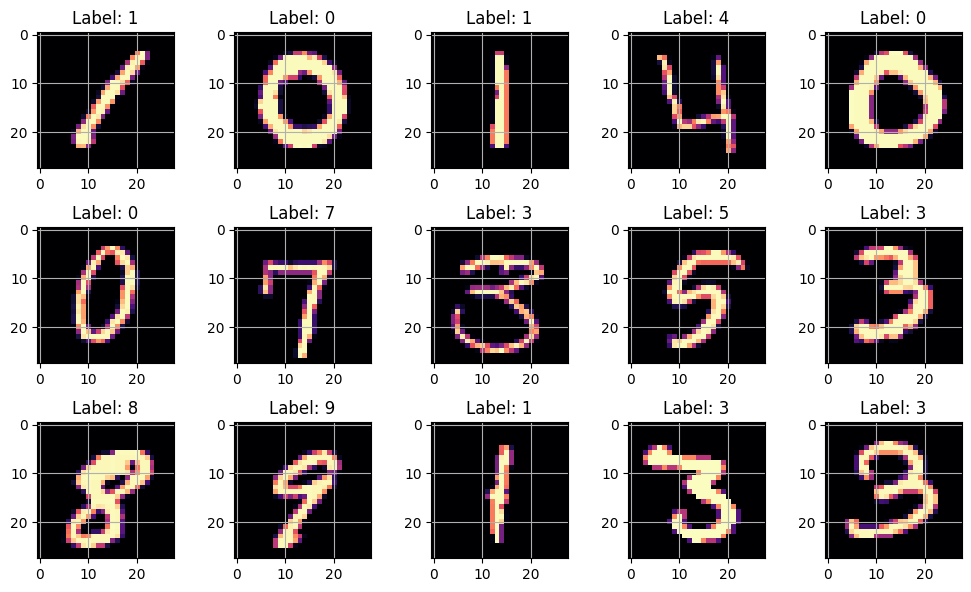

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extraire les pixels et les labels des données d'entraînement
pixels = train_ds.drop('label', axis=1).values
labels = train_ds['label'].values

# Affiche les 10 premières images avec leur titre :
fig, axes = plt.subplots(3, 5, figsize=(10, 6)) # 2 lignes avec 5 colonnes
axes = axes.flatten()


for i in range(15):
    img = pixels[i].reshape(28, 28)  # Remodeler les pixels en une image 28x28 (norme)
    axes[i].imshow(img, cmap='magma') # magma because it's a personal choice i like it !
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].grid(True) # i don't know if the grid is good or not but i like it too so..
  
plt.tight_layout()
plt.show()

## Pré-traitement des données :

__Prétraitement des données :__

- la normalisation des pixels (mettre les pixels à une échelle de 0 à 1)
- le redimensionnement des images (si entrée modéle spécifique)
- l'augmentation des données. (pour augmenter la taille du modéle et améliore la généralisation du modéle)




In [ ]:
from sklearn.preprocessing import RobustScaler
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Normalisation des données :

In [ ]:
# Normalisation robuste des pixels
scaler = RobustScaler()
normalized_pixels = scaler.fit_transform(pixels)

### Redimension des données : 

In [ ]:
# Normalisation robuste des pixels
scaler = RobustScaler()
normalized_pixels = scaler.fit_transform(pixels)

# Redimensionnement des images
resized_images = np.array([resize(img.reshape(28, 28), (28, 28), anti_aliasing=True) for img in normalized_pixels])

# Ajouter une dimension pour les canaux de couleur (niveaux de gris)
resized_images = resized_images.reshape(resized_images.shape + (1,))

### Augmentation des données :

In [ ]:
# Augmentation des données
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
datagen.fit(resized_images)  # Adapter le générateur aux données

# Générer les images augmentées
augmented_images = datagen.flow(resized_images, batch_size=1, shuffle=False)

### Visualisation du pré-traitement : 

L'augmentation des données permet de mettre de la variabilité dans les données en appliquant des transformations aléatoires aux images existantes. 

Ca améliore la capacité de généralisation du modèle en lui donnant plus de données pour l'apprentissage du modéle.

In [ ]:
print("Dimensions des données originales :", resized_images.shape)
print("Dimensions des données augmentées :", augmented_images[0][0].shape)

Dimensions des données originales : (42000, 28, 28, 1)
Dimensions des données augmentées : (28, 28, 1)


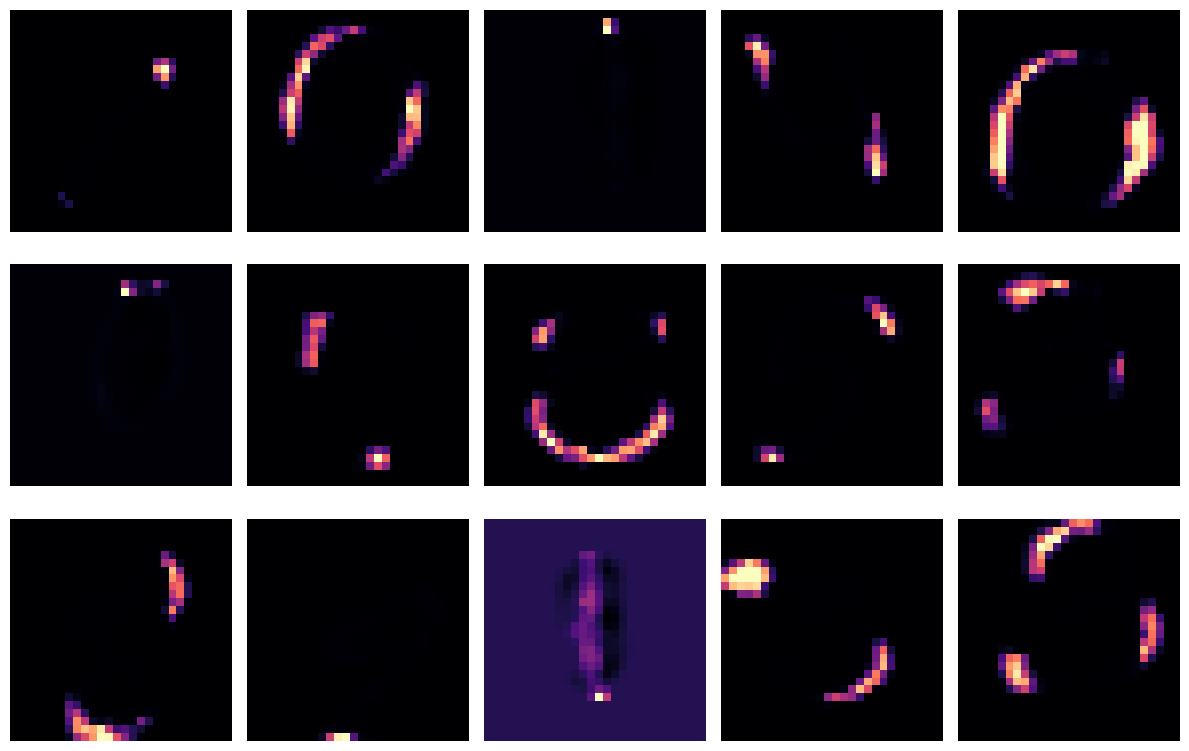

In [45]:
# Génération des images augmentées :
generated_images = datagen.flow(resized_images, batch_size=1, shuffle=False)

# Affichage des images augmentées :
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.flatten()

for i in range(15):
    img = generated_images[i][0].reshape(28, 28)  # Remodeler les pixels en une image 28x28 (norme)
    axes[i].imshow(img, cmap='magma') # choix de la couleur d'affichage (cmap)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Split les données :

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
# Diviser les données en ensemble d'entraînement et ensemble de validation
train_images, val_images, train_labels, val_labels = train_test_split(augmented_images, labels, test_size=0.2)

## Création du modéle from scratch :

Un modèle from scratch permet de concevoir un réseau de neurones avec nos caractéristiques définis. 

Grâce à ça, on a un contrôle total sur l'architecture de notre modèle, les hyperparamètres et les techniques d'optimisation que l'on pourra utiliser. 

Malgré tout les avantages, si on entraine un modèle from scratch , ça nécessitera plus de temps et de ressources de calcul, surtout si on posséde un grand nombre d'images et que le modèle est complexe, ce qui pourra amener à un crash de la mémoire ou à un temps de calcul bien trop important..

In [54]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

In [59]:
model_path = "/content/drive/My Drive/Colab Notebooks/digit-recognizer/model_scratch.h5"

if os.path.exists(model_path):

    # Charger le modèle existant :

    model = keras.models.load_model(model_path)
    print("The Model has already been saved.")

else:

    # Création du modèle :

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Compilation du modèle :

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Utilisation de callbacks :

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpointer = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True)
    csv_logger = CSVLogger('/content/drive/My Drive/Colab Notebooks/digit-recognizer/model_scratch.log')

    # Entraînement du modèle :

    history = model.fit(datagen.flow(train_images, train_labels, batch_size=32), 
                epochs=50, 
                validation_data=(val_images, val_labels),
                callbacks=[early_stopping, checkpointer, csv_logger])

Epoch 1/50
1050/1050 [==============================] - 50s 46ms/step - loss: 1.0125 - accuracy: 0.6764 - val_loss: 0.4031 - val_accuracy: 0.8708
Epoch 2/50
1050/1050 [==============================] - 48s 46ms/step - loss: 0.4306 - accuracy: 0.8596 - val_loss: 0.2487 - val_accuracy: 0.9165
Epoch 3/50
1050/1050 [==============================] - 49s 46ms/step - loss: 0.2850 - accuracy: 0.9096 - val_loss: 0.1832 - val_accuracy: 0.9392
Epoch 4/50
1050/1050 [==============================] - 48s 46ms/step - loss: 0.2068 - accuracy: 0.9334 - val_loss: 0.1588 - val_accuracy: 0.9492
Epoch 5/50
1050/1050 [==============================] - 51s 49ms/step - loss: 0.1742 - accuracy: 0.9435 - val_loss: 0.1188 - val_accuracy: 0.9623
Epoch 6/50
1050/1050 [==============================] - 51s 48ms/step - loss: 0.1552 - accuracy: 0.9502 - val_loss: 0.1019 - val_accuracy: 0.9679
Epoch 7/50
1050/1050 [==============================] - 48s 45ms/step - loss: 0.1359 - accuracy: 0.9571 - val_loss: 0.1132 -

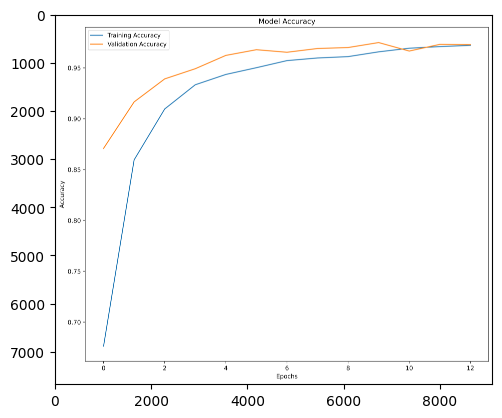

In [61]:
accuracy_plot_path = "/content/drive/My Drive/Colab Notebooks/digit-recognizer/scratch_1.png"

if not os.path.exists(accuracy_plot_path):
    plt.figure(figsize=(12, 10))
    plt.title('Model Accuracy')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.savefig(accuracy_plot_path, transparent=False, bbox_inches='tight', dpi=900)
    plt.grid(True)
    plt.show()
else:
    plt.imshow(plt.imread(accuracy_plot_path))
    plt.show()

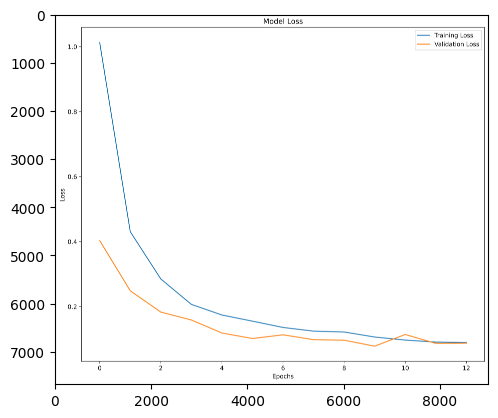

In [64]:
loss_plot_path = "/content/drive/My Drive/Colab Notebooks/digit-recognizer/scratch_2.png"


if not os.path.exists(loss_plot_path):
    plt.figure(figsize=(12, 10))
    plt.title('Model Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.savefig(loss_plot_path, transparent=False, bbox_inches='tight', dpi=900)
    plt.grid(True)
    plt.show()
else:
    plt.imshow(plt.imread(loss_plot_path))